# АБ тесты: введение в проблематику

АБ-тестирование - это подход, позволяющий проверять эффективность нововведений, и главным образом именно ради этого мы учили статистику. 

Задание, направленное на самостоятельный анализ набора данных и статистическую проверку результатов АБ-теста. 

# Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

**Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.**

**Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.**

В данных вы найдете логи заказов пользователей:
<ul>
<li>ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи</li>
<li>ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ</li>
<li>ab_products – подробная информация о продуктах, их название и стоимость</li>
</ul>

### Описание данных

- `user_id` – id пользователя 
- `order_id` – id заказа
- `action` – статус заказа (create_order - создан, cancel_order - отменен)
- `time` – дата и время заказа (YYYY-MM-DD HH:MM:SS) (в т.ч. отмененного)
- `date` – дата (YYYY-MM-DD)
- `group` – номер группы пользователя (0 - старая система рекомендаций, 1 - новая)
- `creation_time` – дата и время создания заказа (YYYY-MM-DD HH:MM:SS) (без отмененных)
- `product_ids` – список id продуктов в заказе
- `product_id` – id продукта 
- `name` – название продукта 
- `price` – цена продукта 

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные и изучим их

2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположение, которое будем тестировать 
    - Построим графики
    
   **Тестируем гипотезы:**
     - Выбираем гипотезы
     - Выбираем подходящие тесты
     - Тестируем
     
3. **Подводим итоги:**
    - Формулируем вывод и суммаризируем всё что было
    - Отвечаем на заданный вопрос: стоит ли включать новую систему рекомендаций на всех пользователей.

In [1]:
# Выгружаем нужные библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2 
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Читаем наши файлы с пользователями, заказами и товарами
# Столбцы с датами парсим как даты
users    = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/ab_users_data.csv', parse_dates = ['time', 'date'])
orders   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/ab_orders.csv', parse_dates = ['creation_time'])
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/ab_products.csv')

In [3]:
# Изучим поподробнее наши данные

In [4]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [5]:
users.shape

(4337, 6)

In [6]:
users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [7]:
users.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [8]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [9]:
orders.shape

(4123, 3)

In [10]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [11]:
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

Формат записи данных в столбце product_ids нам не подходит, изменим его, чтоб можно было вычленять из списков элементы. 

Также посмотрим наиболее часто встречаемые товары в заказах.

In [12]:
orders.product_ids = orders.product_ids.apply(lambda x: x.strip('{}').split(', '))
orders.product_ids.explode(ignore_index=True).value_counts()

20    293
65    291
40    288
77    287
1     285
     ... 
61     34
36     30
73     30
13     24
11     24
Name: product_ids, Length: 87, dtype: int64

In [13]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [14]:
# Проверим самый часто встречаемый товар в заказах
orders.product_ids.mode()

0    [20]
dtype: object

In [15]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


Посмотрим, что за товар с id 20 покупают чаще всего:

In [16]:
products.query('product_id == 20')

,product_id,name,price
19,20,батон,50.0


In [17]:
products.shape

(87, 3)

In [18]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [19]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [20]:
# Посмотрим какие есть статусы заказа
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [21]:
# какие даты
users.date.unique()

array(['2022-08-26T00:00:00.000000000', '2022-08-27T00:00:00.000000000',
       '2022-08-28T00:00:00.000000000', '2022-08-29T00:00:00.000000000',
       '2022-08-30T00:00:00.000000000', '2022-08-31T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-09-02T00:00:00.000000000',
       '2022-09-03T00:00:00.000000000', '2022-09-04T00:00:00.000000000',
       '2022-09-05T00:00:00.000000000', '2022-09-06T00:00:00.000000000',
       '2022-09-07T00:00:00.000000000', '2022-09-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

**Видим не очень большой временной промежуток, возможно некоторые эффекты не успеют себя проявить**

У нас есть похожие столбцы users.time и orders.creation_time. Проверим число их уникальных значений, один ли и тот же это столбец?

In [22]:
users.time.nunique()

4312

In [23]:
orders.creation_time.nunique()

4098

Различия есть. Вероятно, в df orders указаны только не отмененные заказы. Проверим это:

In [24]:
users.query('action == "cancel_order"').count()

user_id     214
order_id    214
action      214
time        214
date        214
group       214
dtype: int64

In [26]:
users.time.nunique() - orders.creation_time.nunique()

214

Так и есть, в df orders указаны только не отмененные заказы

 **Проверим распределения на нормальность по 1000 элементов в контрольной и тестовой группе с помощью теста Шапиро-Уилка.**
- $H_0$: распределение нормальное
- $H_1$: распределение не нормальное

In [27]:
ss.shapiro(users[users['group'] == 0]['time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.8447670936584473, pvalue=3.6299205368081476e-30)

In [28]:
ss.shapiro(users[users['group'] == 1]['time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.8997492790222168, pvalue=4.858138748083447e-25)

По результатам распределения данных в df users у нас не нормальные, так что придется использовать соответствующие статистические тесты.
Т.к. выборки достаточно большие, это не должно повлиять на правильность результатов анализа.

## 2: графики, гипотезы и тесты

**Наши метрики, которые отвечают за качество сервиса:**
  - число пользователей (то же что и число заказов) (считаем не отмененные)
  - churn / отток (процент пользователей с 1 заказом)
  - процент отмененных заказов
  - average order value / AOV (средняя сумма покупки)
  - среднее количество товаров в заказе

Необходимо исследовать данные метрики и статистически сравнить их в двух группах.

 **- число пользователей**

Количество пользователей в каждой группе:

In [29]:
users.group.value_counts()

1    2646
0    1691
Name: group, dtype: int64

Посмотрим на число уникальных пользователей, совершивших заказ (в т.ч. отмененный), с разбивкой по группам:

In [30]:
users.groupby('group', as_index = False).agg({'user_id' : 'nunique'})

,group,user_id
0,0,515
1,1,502


In [33]:
cancel = users.groupby('order_id', as_index = False).agg({'action' : 'count'}).query('action == 2')
# те, кто создал и отменил заказ
cancel

,order_id,action
3,1258,2
35,1296,2
37,1298,2
45,1308,2
51,1315,2
...,...,...
4010,54938,2
4043,56612,2
4047,56772,2
4094,58492,2


Уберем тех, кто отменил заказ:

In [34]:
users_group = users \
    .query('order_id not in @cancel.order_id') \
    .groupby('group', as_index = False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns={'user_id' : 'unique_user_id'})

users_group

,group,unique_user_id
0,0,512
1,1,501


Число пользователей, совершивших заказ (БЕЗ ОТМЕН), с разбивкой по группам:

In [35]:
users.query('order_id not in @cancel.order_id').groupby('group', as_index = False).agg({'user_id' : 'count'})

,group,user_id
0,0,1527
1,1,2382


In [36]:
# Объединим данные и добавим столбец, в котором будет число пользователей/заказов на 1 уникального пользователя

users_group = users_group.merge(users.query('order_id not in @cancel.order_id').groupby('group', as_index = False).agg({'user_id' : 'count'}), on = 'group')
users_group['users_count'] = users_group.user_id / users_group.unique_user_id
users_group

,group,unique_user_id,user_id,users_count
0,0,512,1527,2.982422
1,1,501,2382,4.754491


Text(0.5, 1.0, 'Count of users/orders per 1 unique user depending on group\n')

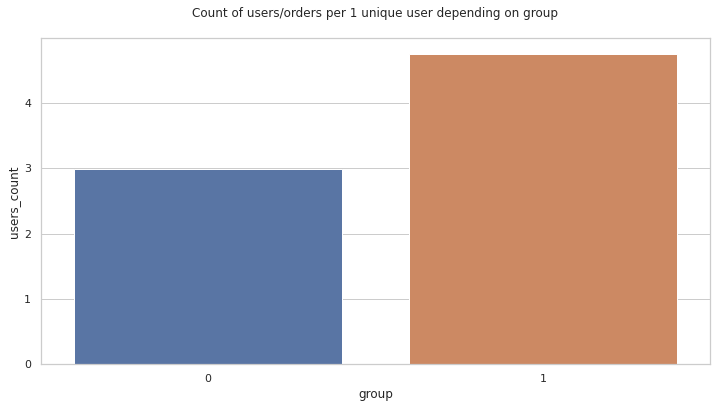

In [37]:
sns.barplot(data = users_group, x = 'group', y = 'users_count')
plt.title('Count of users/orders per 1 unique user depending on group\n')

Видим, что с новой системой рекомендаций при изначательно примерно одинаковом числе уникальных пользователей суммарное число пользователей, которые делают заказы, стало больше. Посмотрим, значимо ли различаются цифры.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [38]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users.group, users.user_id))

In [39]:
stat, p

(4337.0, 0.0)

Интерпретируем результат:

In [40]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**Нулевую гипотезу отклоняем, следовательно, мы не можем отвергать взаимосвязь между переменными, увеличение числа пользователей статистически значимо.**

  **- churn / отток (процент пользователей с 1 заказом)**

In [41]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


Посчитаем, сколько заказов (исключая отмененные заказы) у каждого пользователя:

In [42]:
churn = users.query('order_id not in @cancel.order_id').groupby('user_id', as_index = False).agg({'order_id' : 'count'})
churn

,user_id,order_id
0,964,2
1,965,9
2,967,5
3,968,3
4,969,2
...,...,...
1008,1976,5
1009,1977,4
1010,1978,6
1011,1979,5


Добавим столбец с номером группы:

In [43]:
churn = churn.join(users.group, on = 'user_id')

In [44]:
churn.head()

,user_id,order_id,group
0,964,2,0
1,965,9,1
2,967,5,0
3,968,3,0
4,969,2,1


In [45]:
# проверим все ли ок
churn.isna().sum()

user_id     0
order_id    0
group       0
dtype: int64

Построим гистограмму распределения количества заказов у пользователей в зависимости от группы:

Text(0.5, 1.0, 'Order count depending on group\n')

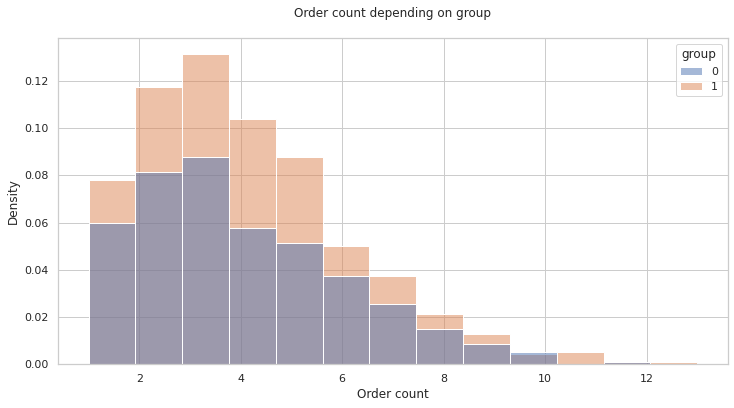

In [46]:
sns.histplot(data = churn, hue = 'group', x = 'order_id', stat = 'density', bins = 13)
plt.xlabel('Order count')
plt.title('Order count depending on group\n')

Видим, что просто суммарное число заказов в 1 группе больше, чем во второй, но тенденция в обеих группах примерно одинаковая.

Посчитаем число пользователей с 1 заказом с разбивкой по группам:

In [47]:
churn_users = churn.query('order_id == 1').groupby('group', as_index = False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'users_1_order'})
churn_users

,group,users_1_order
0,0,56
1,1,73


Суммарное число пользователей:

In [48]:
churn.groupby('group', as_index = False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'users_order'})

,group,users_order
0,0,403
1,1,610


In [49]:
churn_users = churn_users.merge(churn.groupby('group', as_index = False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'users_order'}), on = 'group')
churn_users

,group,users_1_order,users_order
0,0,56,403
1,1,73,610


Тогда процент тех, кто совершил всего 1 заказ:

In [50]:
churn_users['churn'] = churn_users.users_1_order / churn_users.users_order * 100
churn_users

,group,users_1_order,users_order,churn
0,0,56,403,13.895782
1,1,73,610,11.967213


Text(0.5, 1.0, 'Churn depending on group\n')

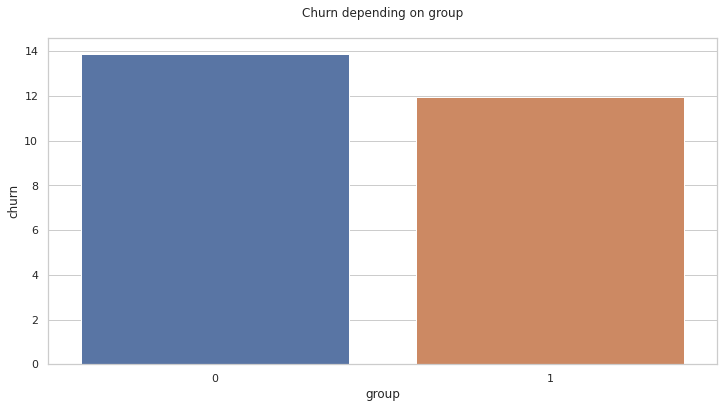

In [51]:
sns.barplot(data = churn_users, x = 'group', y = 'churn')
plt.title('Churn depending on group\n')

На первый взгляд разница в цифрах не существенна, но проверим это с при помощи теста.

Есть ли значимая разница в количестве заказов между группами? 
Проверим распределения на нормальность:

- $H_0$: распределения нормальные
- $H_1$: распределения не нормальные

In [53]:
pg.normality(data=churn, dv="order_id", 
                   group="group", method="normaltest")

,W,pval,normal
0,35.416278,2.039168e-08,False
1,75.466624,4.098556e-17,False


Т.к. распределения у нас не нормальные, будем использовать критерий Краскела-Уоллиса:
- $H_0$: взаимосвязи между оттоком и группой нет 
- $H_1$: взаимосвязь есть

In [54]:
ss.kruskal(churn.query('group == 0').order_id, churn.query('group == 1').order_id)

KruskalResult(statistic=0.5101187262405538, pvalue=0.4750874649212178)

In [56]:
# тест Манна-Уитни
ss.mannwhitneyu(churn.query('group == 0').order_id, churn.query('group == 1').order_id)

MannwhitneyuResult(statistic=119697.0, pvalue=0.47515607785612957)

**Наше p-value > 0.05, т.е. взаимосвязи между переменными нет, отток пользователей не зависит от номера группы.**

  **- процент отмененных заказов**

Посчитаем количество не отмененных и отмененных заказов с разбивкой по группам:

In [57]:
users_action = users.query('order_id not in @cancel.order_id').groupby('group', as_index = False).agg({'order_id' : 'count'})
users_action

,group,order_id
0,0,1527
1,1,2382


In [58]:
users.query('order_id in @cancel.order_id').groupby('group', as_index = False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'cancel_order'})

,group,cancel_order
0,0,164
1,1,264


In [59]:
users_action = users_action.merge(users.query('order_id in @cancel.order_id').groupby('group', as_index = False).agg({'order_id' : 'count'}).rename(columns={'order_id' : 'cancel_order'}), on = 'group')
users_action

,group,order_id,cancel_order
0,0,1527,164
1,1,2382,264


Добавим процент отмененных заказов по группам:

In [60]:
users_action['per_cancel_orders'] = users_action.cancel_order / (users_action.cancel_order + users_action.order_id) * 100
users_action

,group,order_id,cancel_order,per_cancel_orders
0,0,1527,164,9.698403
1,1,2382,264,9.977324


Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными action и group нет 
- $H_1$: взаимосвязь есть

In [61]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users.action, users.group))

In [62]:
stat, p

(0.018211165651942023, 0.8926523935841298)

In [63]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


**H0 не отклоняем, взаимосвязи между переменными нет.**

 **- average order value / AOV (средняя сумма покупки)**
 
 считаем среднее, т.к. количество заказов в группах разное

Для вычисления суммы покупки с разбивкой по группам нужно объединить df с убрать лишние колонки для удобства:

In [64]:
df = orders.merge(users, on = 'order_id', how = 'left')

In [65]:
df = df.drop(columns = {'creation_time', 'user_id', 'time', 'date'})

In [66]:
df.head()

,order_id,product_ids,action,group
0,1255,"[75, 22, 53, 84]",create_order,0
1,1256,"[56, 76, 39]",create_order,1
2,1257,"[76, 34, 41, 38]",create_order,0
3,1258,"[74, 6]",create_order,0
4,1258,"[74, 6]",cancel_order,0


Разделяем наш заказ по товарам с помощью explode:

In [67]:
df = df.explode('product_ids')
df = df.rename(columns = {'product_ids' : 'product_id'})
df

,order_id,product_id,action,group
0,1255,75,create_order,0
0,1255,22,create_order,0
0,1255,53,create_order,0
0,1255,84,create_order,0
1,1256,56,create_order,1
...,...,...,...,...
4335,59487,9,create_order,0
4335,59487,62,create_order,0
4335,59487,77,create_order,0
4336,59533,17,create_order,0


In [68]:
df.shape

(14569, 4)

In [69]:
df.dtypes
# нужно поменять тип данных столбца product_id на int, иначе не получится объединить df

order_id       int64
product_id    object
action        object
group          int64
dtype: object

In [70]:
df['product_id'] = df['product_id'].astype('int')

In [71]:
df.dtypes

order_id       int64
product_id     int64
action        object
group          int64
dtype: object

In [72]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [73]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

Уберем отмененные заказы и можно мерджить с ценами:

In [74]:
df = df.query('order_id not in @cancel.order_id').drop(columns={'action'})
df.head()

,order_id,product_id,group
0,1255,75,0
0,1255,22,0
0,1255,53,0
0,1255,84,0
1,1256,56,1


In [75]:
df.shape

(13083, 3)

In [76]:
df = df.merge(products, on = 'product_id')
df

,order_id,product_id,group,name,price
0,1255,75,0,сок ананасовый,120.0
1,1287,75,0,сок ананасовый,120.0
2,1403,75,1,сок ананасовый,120.0
3,1424,75,1,сок ананасовый,120.0
4,1495,75,1,сок ананасовый,120.0
...,...,...,...,...,...
13078,33910,11,1,масло льняное,200.0
13079,34742,11,0,масло льняное,200.0
13080,41998,11,1,масло льняное,200.0
13081,53851,11,0,масло льняное,200.0


Теперь можно посчитать среднюю стоимость заказов по группам:

In [77]:
df.groupby(['group', 'order_id'], as_index = False).agg({'price' : 'sum'}).groupby('group', as_index = False).agg({'price' : 'mean'})

,group,price
0,0,382.092927
1,1,368.861629


In [79]:
order_price = df.groupby(['group', 'order_id'], as_index = False).agg({'price' : 'sum'})
order_price

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1261,430.7
3,0,1262,358.6
4,0,1265,546.4
...,...,...,...
3904,1,59220,264.2
3905,1,59250,150.3
3906,1,59390,620.8
3907,1,59422,241.2


Судя по полученных данным, средняя сумма заказа по группам не сильно различается. Построим распредления сумм.

Text(0.5, 1.0, 'Order price depending on group\n')

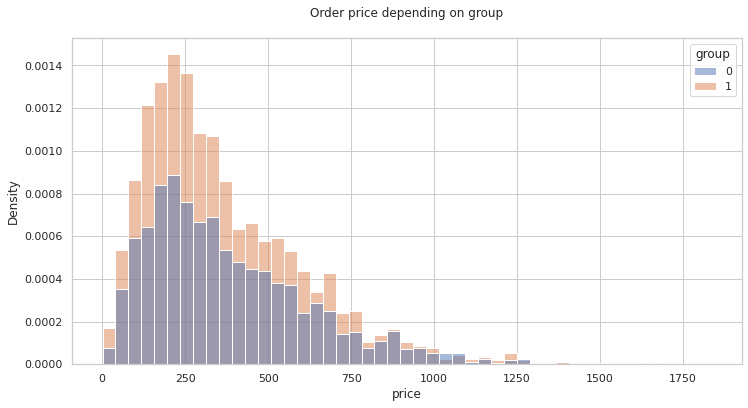

In [80]:
sns.histplot(data = order_price, hue = 'group', x = 'price', stat = 'density')
plt.title('Order price depending on group\n')

Есть ли значимая разница в средней сумме заказа между группами? 
Проверим распределения на нормальность:

- $H_0$: распределения нормальные
- $H_1$: распределения не нормальные

In [82]:
pg.normality(data=order_price, dv="price", 
                   group="group", method="normaltest")

,W,pval,normal
0,276.039777,1.144785e-60,False
1,586.947838,3.514766e-128,False


Т.к. распределения у нас не нормальные, будем использовать критерий Краскела-Уоллиса:
- $H_0$: взаимосвязи между суммой заказа и группой нет 
- $H_1$: взаимосвязь есть

In [83]:
ss.kruskal(order_price.query('group == 0').price, order_price.query('group == 1').price)

KruskalResult(statistic=3.1612228194889664, pvalue=0.0754066806530465)

In [84]:
pg.ttest(order_price.query('group == 0').price, order_price.query('group == 1').price)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.631329,3238.536101,two-sided,0.102918,"[-2.67, 29.13]",0.05355,0.139,0.372043


In [85]:
pg.mwu(order_price.query('group == 0').price, order_price.query('group == 1').price)

,U-val,alternative,p-val,RBC,CLES
MWU,1879866.0,two-sided,0.075409,-0.033656,0.516828


**Наше p-value > 0.05, т.е. взаимосвязи между переменными нет, сумма заказа не зависит от номера группы.**

  **- среднее количество товаров в заказе**

In [86]:
count_items = df.groupby(['group', 'order_id'], as_index = False).agg({'price' : 'count'}).rename(columns={'price' : 'count_items'})
count_items.head()

,group,order_id,count_items
0,0,1255,4
1,0,1257,4
2,0,1261,4
3,0,1262,4
4,0,1265,5


Добавим распределение количеств позиций в заказах в разрезе по группам:

Text(0.5, 1.0, 'Count items in order depending on group\n')

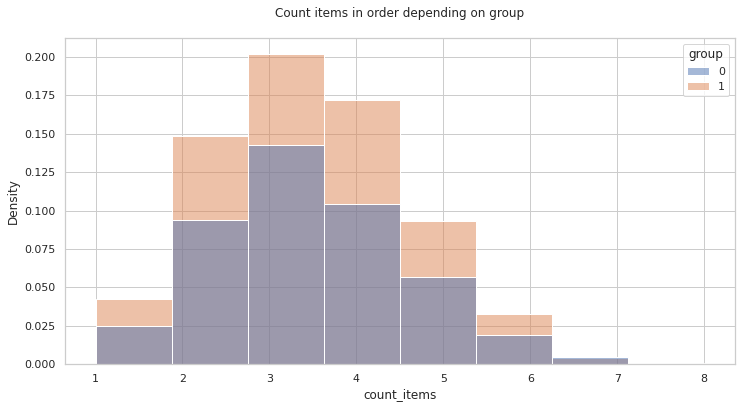

In [87]:
sns.histplot(data = count_items, hue = 'group', x = 'count_items', stat = 'density', bins = 8)
plt.title('Count items in order depending on group\n')

In [88]:
count_items.groupby('group', as_index = False).agg({'count_items' : 'mean'})

,group,count_items
0,0,3.341847
1,1,3.350126


Среднее количество позиций в заказе также существенно не изменилось. Но подтвердим это статистическим тестом.

Есть ли значимая разница в количестве позиций в заказе между группами? 
Проверим распределения на нормальность:

- $H_0$: распределения нормальные
- $H_1$: распределения не нормальные

In [89]:
pg.normality(data=count_items, dv="count_items", 
                   group="group", method="normaltest")

,W,pval,normal
0,36.287512,1.319067e-08,False
1,42.201912,6.854430e-10,False


Т.к. распределения у нас не нормальные, будем использовать критерий Краскела-Уоллиса:
- $H_0$: взаимосвязи между суммой заказа и группой нет 
- $H_1$: взаимосвязь есть

In [90]:
ss.kruskal(count_items.query('group == 0').count_items, count_items.query('group == 1').count_items)

KruskalResult(statistic=0.13996411804481115, pvalue=0.7083166864098527)

**Наше p-value > 0.05, т.е. взаимосвязи между переменными нет, количество позиций в заказе не зависит от номера группы.**

## 3: итоги

**Были найдены и сравнены метрики, которые отвечают за качество сервиса:**
  - число пользователей (то же что и число заказов) (считаем не отмененные)
  - churn / отток (процент пользователей с 1 заказом)
  - процент отмененных заказов
  - average order value / AOV (средняя сумма покупки)
  - среднее количество товаров в заказе
  
Положительную статистически значимую тенденцию показала только первая метрика - число пользователей/заказов, их стало больше. Остальные метрики статистически значимо не различимы.

На данном этапе включать новую систему рекомендаций на всех пользователей не стоит. Можно продлить эксперимент и пронаблюдать за результатом.

 

### Ревью:

Подготовка данных: 4/4 Подготовка и предварительный анализ вполне ок, визуализация тоже подходящая! Также корректно отсеяны отменённые заказы. 

Проверка гипотез: 6/6 Хорошие идеи для метрик и их проверки! Замечу, правда, но на выборке такого размера нормальность не играет такой уж важной роли. Не очень понятно, кстати, почему ты берёшь именно Краскала-Уоллеса, а не Манна-Уитни - так как это одно и то же, только Краскал для числа групп >= 2. Ещё замечу, что заказы внутри одного пользователя могут быть скоррелированы, и позаказные метрики поэтому в продвинутых АБ-тестах обсчитываются более хитрым образом. 

Рассуждения и выводы: 3/5 Я бы оспорил твой вывод - если ты посмотришь на выручку, то она тоже как раз выросла (как следствие роста числа заказов и неизменившегося среднего чека). Также обрати внимание, что гипотеза о независимости касается хи-квадрата, но не Краскала-Уоллеса. Итого: 13/15»

Полученный балл: 13.00